<a href="https://colab.research.google.com/github/tesseract314/DS-Unit-2-Sprint-4-Model-Validation/blob/master/LS_DS2_24_Cross_Validation_AND_Feature_Selection_LIVE_LESSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science - Model Validation_

## Example solution to the Cross-Validation assignment — plus Feature Selection!

See also Sebastian Raschka's example, [Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb).

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.


import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

    
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    
    return X_train, X_test, y_train, y_test


def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X


def wrangle(X):
    # From DS1 friends!
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    X['PRCP_yest'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_ln'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    return X

In [0]:
# Download and join data into a dataframe
data = load()

In [3]:
%%time

# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

# Define an estimator and param_grid
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print('Best estimator:', gs.best_estimator_, '\n')
print('Cross-Validation Score:', -validation_score, '\n')

Fitting 3 folds for each of 105 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=30, score_func=<function f_regression at 0x7fc1abb897b8>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]) 

Cross-Validation Score: 297.14146030845217 

CPU times: user 7.35 s, sys: 4.66 s, total: 12 s
Wall time: 6.19 s


[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    5.9s finished


In [4]:
# Predict with X_test features
y_pred = gs.predict(X_test)

# Compare predictions to y_test labels
test_score = mean_absolute_error(y_test, y_pred)
print('Test Score:', test_score)

Test Score: 321.98359011482916


In [6]:
# Or use the grid search's score method, 
# which combines these steps
test_score = gs.score(X_test, y_test)
print('Test Score:', -test_score)

Test Score: 321.98359011482916


In [10]:
type(gs.best_estimator_.named_steps['selectkbest'])

sklearn.feature_selection.univariate_selection.SelectKBest

In [11]:
selector.get_support()

array([ True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True])

In [12]:
all_names

Index(['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'PRCP_yest',
       'Windchill', 'Rl_Cold', 'TMIN_ln', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='object')

In [7]:
# Which features were selected?
selector = gs.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask] # Inverting True and False

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
annual
PRCP_yest
Windchill
Rl_Cold
TMIN_ln
Jan
Feb
Mar
May
Jun
Jul
Aug
Sep
Nov
Dec

Features not selected:
SNOW
SNWD
Fri
Apr
Oct


## BONUS: Recursive Feature Elimination!

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [13]:
from sklearn.feature_selection import RFECV

X_train_scaled = RobustScaler().fit_transform(X_train)
rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', cv=3)
X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

all_names = X_train.columns
selected_mask = rfe.support_
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Fri
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
Windchill
Rl_Cold
TMIN_ln
Mar
May
Jun
Oct
Dec

Features not selected:
SNOW
SNWD
annual
PRCP_yest
Jan
Feb
Apr
Jul
Aug
Sep
Nov


In [0]:
X_train_subset = pd.DataFrame(X_train_subset, columns=selected_names)

In [15]:
X_train.shape, X_train_subset.shape

((963, 35), (963, 24))

In [0]:
X_test_subset = rfe.transform(X_test)
X_test_subset = pd.DataFrame(X_test_subset, columns=selected_names)

In [17]:
X_test.shape, X_test_subset.shape

((100, 35), (100, 24))

In [19]:
X_train_subset.head()

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,...,Temp (C),dry day,Windchill,Rl_Cold,TMIN_ln,Mar,May,Jun,Oct,Dec
0,0.0,0.45,0.068493,1.894737,0.726115,0.0,0.0,0.0,1.0,0.0,...,0.318841,0.0,-0.111571,1.351748,0.068493,0.0,0.0,0.0,1.0,0.0
1,0.0,0.73,0.150685,1.473684,0.696815,0.0,0.0,0.0,0.0,1.0,...,0.515942,0.0,0.151782,1.078217,0.156301,0.0,0.0,0.0,1.0,0.0
2,0.0,0.95,0.000000,1.157895,0.488535,0.0,0.0,0.0,0.0,0.0,...,0.579710,0.0,0.271086,0.879220,0.000000,0.0,0.0,0.0,1.0,0.0
3,0.0,0.95,0.000000,-0.842105,-0.238854,0.0,0.0,0.0,0.0,0.0,...,0.579710,0.0,0.895435,-1.143885,0.000000,0.0,0.0,0.0,1.0,0.0
4,0.0,0.67,0.000000,-0.526316,-0.152229,1.0,0.0,0.0,0.0,0.0,...,0.417391,0.0,0.587911,-0.624901,0.000000,0.0,0.0,0.0,1.0,0.0


In [20]:
X_test_subset.head()

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,...,Temp (C),dry day,Windchill,Rl_Cold,TMIN_ln,Mar,May,Jun,Oct,Dec
0,0.0,15.6,11.1,27.0,1776.0,1.0,0.0,0.0,0.0,0.0,...,13.35,1.0,18.657733,2.984593,123.21,0.0,1.0,0.0,0.0,0.0
1,0.0,21.7,11.7,21.0,1737.0,0.0,1.0,0.0,0.0,0.0,...,16.70,1.0,26.742639,1.842978,136.89,0.0,1.0,0.0,0.0,0.0
2,0.0,24.4,11.7,18.0,4254.0,0.0,0.0,1.0,0.0,0.0,...,18.05,1.0,30.303846,1.214530,136.89,0.0,1.0,0.0,0.0,0.0
3,0.0,27.8,12.2,21.0,4771.0,0.0,0.0,0.0,1.0,0.0,...,20.00,1.0,32.730525,1.816375,148.84,0.0,1.0,0.0,0.0,0.0
4,0.0,26.1,12.8,25.0,5142.0,0.0,0.0,0.0,0.0,1.0,...,19.45,1.0,30.469309,2.522606,163.84,0.0,1.0,0.0,0.0,0.0


In [21]:
print(X_train.shape, X_train_subset.shape, X_test.shape, X_test_subset.shape)

(963, 35) (963, 24) (100, 35) (100, 24)


# RFE again, but with polynomial features and interaction terms!

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_polynomial = poly.fit_transform(X_train)

print(X_train.shape, X_train_polynomial.shape)

(963, 35) (963, 666)


In [23]:
from sklearn.feature_selection import RFECV

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_polynomial)

rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', 
            step=10, cv=3, verbose=1)

X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

Fitting estimator with 666 features.
Fitting estimator with 656 features.
Fitting estimator with 646 features.
Fitting estimator with 636 features.
Fitting estimator with 626 features.
Fitting estimator with 616 features.
Fitting estimator with 606 features.
Fitting estimator with 596 features.
Fitting estimator with 586 features.
Fitting estimator with 576 features.
Fitting estimator with 566 features.
Fitting estimator with 556 features.
Fitting estimator with 546 features.
Fitting estimator with 536 features.
Fitting estimator with 526 features.
Fitting estimator with 516 features.
Fitting estimator with 506 features.
Fitting estimator with 496 features.
Fitting estimator with 486 features.
Fitting estimator with 476 features.
Fitting estimator with 466 features.
Fitting estimator with 456 features.
Fitting estimator with 446 features.
Fitting estimator with 436 features.
Fitting estimator with 426 features.
Fitting estimator with 416 features.
Fitting estimator with 406 features.
F

In [24]:
all_names = poly.get_feature_names(X_train.columns)
selected_mask = rfe.support_
selected_names = [name for name, selected in zip(all_names, selected_mask) if selected]

print(f'{rfe.n_features_} Features selected:')
for name in selected_names:
    print(name)

156 Features selected:
PRCP
TMAX
Sun
holiday
daylight_hrs
Temp (C)
annual
Mar
May
Nov
PRCP Tue
PRCP Fri
PRCP Sat
PRCP Sun
PRCP holiday
PRCP daylight_hrs
PRCP Jan
PRCP Feb
PRCP Mar
PRCP Apr
PRCP May
PRCP Jun
PRCP Jul
PRCP Aug
PRCP Sep
PRCP Nov
PRCP Dec
TMAX^2
TMAX TMIN
TMAX Rl_Cold
TMIN AWND
TMIN Total_yesterday
TMIN Windchill
AWND^2
AWND Total_yesterday
AWND daylight_hrs
AWND Temp (C)
AWND dry day
AWND annual
AWND Windchill
AWND Rl_Cold
AWND TMIN_ln
Total_yesterday^2
Total_yesterday daylight_hrs
Total_yesterday dry day
Total_yesterday annual
Total_yesterday Rl_Cold
Mon holiday
Mon daylight_hrs
Mon annual
Mon Jan
Mon Feb
Mon Mar
Mon May
Mon Jun
Mon Oct
Mon Nov
Tue daylight_hrs
Tue dry day
Tue annual
Tue Mar
Tue Apr
Tue May
Tue Aug
Tue Sep
Tue Dec
Wed holiday
Wed daylight_hrs
Wed PRCP_yest
Wed Jan
Wed Mar
Wed Apr
Wed Sep
Wed Oct
Thu holiday
Thu daylight_hrs
Thu dry day
Thu annual
Thu PRCP_yest
Thu Jan
Thu Feb
Thu Mar
Thu Apr
Thu May
Thu Jun
Thu Sep
Thu Oct
Thu Nov
Thu Dec
Fri daylight_hr

In [25]:
# Define an estimator and param_grid

ridge = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(ridge, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train_subset, y_train)
validation_score = gs.best_score_
print('Best estimator:', gs.best_estimator_, '\n')
print('Cross-Validation Score:', -validation_score, '\n')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best estimator: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 

Cross-Validation Score: 247.80985367683917 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished


In [26]:
# Do the same transformations to X_test
X_test_polynomial = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_polynomial)
X_test_subset = rfe.transform(X_test_scaled)

# Use the grid search's score method with X_test_subset
test_score = gs.score(X_test_subset, y_test)
print('Test Score:', -test_score)

Test Score: 328.57066776770154


In [27]:
X_test.shape, X_test_polynomial.shape, X_test_scaled.shape, X_test_subset.shape

((100, 35), (100, 666), (100, 666), (100, 156))

# Assignment

with the Bank Marketing dataset:

Do more *data cleaning*, *feature engineering*, and *cross-validation.*

Do *Feature Selection* too, using any method(s), such as:
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://www.kaggle.com/dansbecker/permutation-importance
- https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
- Human expertise / intuition

Submit your predictions to *Kaggle*, and commit your code to *GitHub*!

In [1]:
!pip install category_encoders

In [0]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import category_encoders as ce

In [0]:
def load_split():
  # Retrieving files from github
  !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_features.csv
  !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_labels.csv
  !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/test_features.csv
  !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/sample_submission.csv
  
  # Importing all 4 datasets
  X_train = pd.read_csv('train_features.csv')
  train_labels = pd.read_csv('train_labels.csv')
  y_train = train_labels['y']
  X_test = pd.read_csv('test_features.csv')
  sample_submission = pd.read_csv('sample_submission.csv')
  
  return X_train, train_labels, y_train, X_test, sample_submission

In [0]:
X_train, train_labels, y_train, X_test, sample_submission = load_split()

In [5]:
X_train.shape, y_train.shape, X_test.shape, sample_submission.shape

((30891, 20), (30891,), (10297, 20), (10297, 2))

In [0]:
# making wrangle function
def wrangle(X):
  X = X.copy
  
  # Dropping id column
  X = X.drop(columns='id')
  
  # Feature that has True for calls to client exceeding 10
  X['too_many_calls'] = X['campaign'] > 10
  
  
# Function doesn't work, get's error on 'drop'

In [0]:
# # Wrangling train and test datasets
# X_train = wrangle(X_train)
# X_test = wrangle(X_test)

In [0]:
X_train = X_train.drop(columns='id')
X_test = X_test.drop(columns='id')
# Feature that has True for calls to client exceeding 10
X_train['too_many_calls'] = X_train['campaign'] > 10
X_test['too_many_calls'] = X_test['campaign'] > 10

In [9]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,too_many_calls
0,29,services,single,high.school,no,yes,yes,cellular,may,thu,10,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,False
1,54,management,married,university.degree,no,no,no,cellular,nov,tue,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,False
2,55,self-employed,married,unknown,unknown,no,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,False
3,43,blue-collar,married,unknown,unknown,no,no,cellular,may,mon,6,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,False
4,54,blue-collar,married,basic.4y,no,yes,no,telephone,may,wed,5,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,False


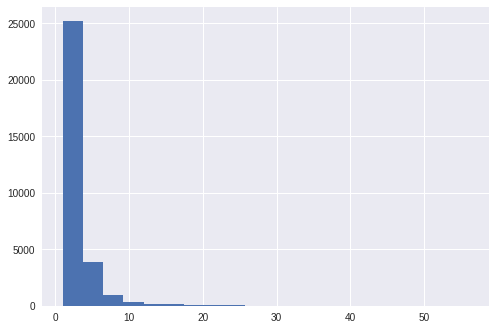

In [10]:
X_train['campaign'].hist(bins=20)

In [0]:
# for column in X_train.columns:
#   print(X_train[column].unique())

#### Baseline

In [15]:
pd.Series(y_train).value_counts(normalize=True)

0    0.887346
1    0.112654
Name: y, dtype: float64

In [0]:
majority_class = 0
y_pred = [majority_class] * len(y_train)

In [17]:
len(y_pred)

30891

In [19]:
roc_auc_score(y_train, y_pred)

0.5

#### Model Val/Feature Selection

In [25]:
# Pipeline
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RobustScaler(),
    SelectKBest(f_classif),
    LogisticRegression(max_iter=1000))

# Param grid
param_grid = {
    'selectkbest__k': range(1, len(X_train.columns) + 1),
    'logisticregression__solver': ['lbfgs', 'liblinear']       
}

gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 17 26 30 34 38 41 52 58 62] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 17 26 30 34 38 41 52 58 62] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 17 26 30 34 38 41 52 58 62] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=None, drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, use_cat_names=True, verbose=0)), ('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selec...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': range(1, 21), 'logisticregression__solver': ['lbfgs', 'liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [26]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'],
       drop_invariant=False, handle_unknown='impute', impute_missing=True,
       return_df=True, use_cat_names=True, verbose=0)), ('robustscaler'...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [29]:
gs.best_score_

0.7860441126705991